In [1]:
#para apagar diretório de modelos quando for gerar novos modelos
#import shutil
#diretorio_a_apagar = './backup'
#shutil.rmtree(diretorio_a_apagar)

In [2]:
#para executar esse projeto é necessário ter a seguintes libs instaladas
#pip install pandas
#pip install scipy
#pip install autogluon
#pip install opendatasets --upgrade
#pip install -U imbalanced-learn
#pip install neurokit2

In [3]:
#libs "básicas"
import os
import csv
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy import stats
import matplotlib.pyplot as plt

#libs que auxiliam os modelos
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#lib para importar base de dados
import opendatasets as od

A base de dados é oficialmente compartilhada pela [PhysioNet](https://www.physionet.org/content/mitdb/1.0.0/), porém, executando a linha a seguir, a mesma base de dados é obtida através da plataforma kaggle com auxílio da biblioteca opendatasets.

In [4]:
od.download("https://www.kaggle.com/datasets/taejoongyoon/mitbit-arrhythmia-database?datasetId=52320&sortBy=voteCount")

Skipping, found downloaded files in "./mitbit-arrhythmia-database" (use force=True to force download)


## Pré processamento
Iremos analisar os modelos com dados sem remoção de ruído e com remoção de ruído

#### Variáveis auxiliares

In [5]:
path = './mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N','L','R','A','V']
n_classes = len(classes)
count_classes = {elemento: 0 for elemento in classes}

X = list()
y = list()

In [6]:
description_beats = {'N':'Batida normal', 'L':'Batida de bloqueio de ramo esquerdo',
                     'R':'Batida de bloqueio de ramo direito','A':'Batimento atrial prematuro',
                     'a':'Batimento atrial prematuro aberrado','J':'Batimento prematuro nodal (juncional)',
                     'S':'Batimento supraventricular prematuro ou ectópico (atrial ou nodal)',
                     'V':'Contração ventricular prematura','F':'Fusão de batimento ventricular e normal',
                     'e':'Batida de escape atrial','j':'Batida de escape nodal (juncional)',
                     'E':'Batida de escape ventricular','/':'Batida ritmada',
                     'f':'Fusão de batida ritmada e normal','Q': 'Batida inclassificável'}

#### Preparo dos arquivos

In [7]:
# Leitura dos arquivos
filenames = next(os.walk(path))[2]

# Para separar e salvar os arquivos em csv e txt
records = list()
annotations = list()
filenames.sort()

In [8]:
# Definindo nomes de arquivos e anotações
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [9]:
len(records), len(annotations)

(48, 48)

#### Extração dos dados e pré processamento sem remoção de rúido

In [10]:
%%time
# Registros
X_with_noise = list() #x contém os valores do sinais
y_with_noise = list() #y para os rótulos
z_with_noise = list() #z indica o índice do registro

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # ler arquivo csv
        next(spamreader) # ignora header
        for row in spamreader:
            signals.append(int(row[1]))
                
    # Normalizando os dados: https://www.investopedia.com/terms/z/zscore.asp
    signals = stats.zscore(signals)
    
    
    with open(annotations[r], 'r') as fileID:
        lines = fileID.readlines()[1:] # 0 índice é o cabeçalho do gráfico, ignora o header

        for line in lines:
            row = list(filter(lambda item: item != '', line.split(' ')))
            time, sample, arrhythmia_type = row[0:3]
            pos = int(sample)

            if(arrhythmia_type in classes): # Verificar se é uma classe válida
                # Contar a quantidade de dados de cada classe
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_type] += 1
                
                # pos é o momento que foi feita a analise.
                if(window_size <= pos and (pos + window_size) < len(signals)):
                    # pega uma janela de tempo onde o pos fica no meio
                    beat = signals[pos-window_size:pos+window_size]
        
                    X_with_noise.append(beat)
                    y_with_noise.append(arrhythmia_index)
                    z_with_noise.append(os.path.splitext(os.path.basename(records[r]))[0])

print(np.shape(X_with_noise), np.shape(y_with_noise))

(100012, 360) (100012,)
CPU times: user 19.9 s, sys: 705 ms, total: 20.6 s
Wall time: 20.6 s


Utilizamos a coluna ``record_id`` afim de facilitar consultas relacionadas a qual registro pertence cada linha em casos de dúvidas, mas a coluna não é utilizada nos modelos.

In [11]:
noisy_database = pd.DataFrame(data=X_with_noise)
noisy_database['label'] = y_with_noise
noisy_database['record_id'] = z_with_noise
noisy_database.head()

,0,1,2,3,4,5,6,7,8,9,...,352,353,354,355,356,357,358,359,label,record_id
0,-0.148556,-0.174436,-0.045036,0.032603,0.032603,0.084363,0.058483,0.084363,0.110243,0.162003,...,-0.122676,-0.122676,-0.200316,-0.200316,-0.200316,-0.070916,-0.122676,-0.148556,0,100
1,-0.329716,-0.303836,-0.277956,-0.303836,-0.174436,-0.096796,-0.045036,-0.070916,-0.122676,-0.122676,...,-0.329716,-0.277956,-0.303836,-0.277956,-0.303836,-0.381476,-0.329716,-0.303836,0,100
2,-0.433236,-0.355596,-0.277956,-0.174436,-0.148556,-0.122676,-0.148556,-0.148556,-0.096796,-0.070916,...,-0.148556,-0.122676,-0.148556,-0.174436,-0.148556,-0.070916,-0.174436,-0.174436,0,100
3,-0.070916,-0.045036,-0.070916,-0.096796,-0.045036,0.058483,0.110243,0.032603,0.058483,0.110243,...,-0.122676,-0.070916,-0.045036,-0.096796,-0.148556,-0.252076,-0.200316,-0.174436,0,100
4,-0.614396,-0.588516,-0.510876,-0.381476,-0.329716,-0.303836,-0.303836,-0.303836,-0.200316,-0.122676,...,-0.019156,-0.019156,-0.122676,-0.148556,-0.122676,-0.070916,-0.096796,-0.096796,0,100


In [12]:
noisy_database.shape

(100012, 362)

In [13]:
noisy_database['label'].value_counts()

0    75011
1     8071
2     7255
4     7129
3     2546
Name: label, dtype: int64

#### Extração dos dados e pré processamento com remoção de rúido

O parâmetro de taxa de amostragem (sampling rate) ideal pode depender da frequência de amostragem original dos seus dados. O ideal é que a taxa de amostragem seja preservada durante todo o processamento para evitar perda de informações importantes.

In [14]:
def denoise(ecg): 
    #sampling_rate ( int ) – A frequência de amostragem do sinal (em Hz, ou seja, amostras/segundo).
    data = nk.ecg_clean(ecg, sampling_rate=360, method="neurokit")     
    return data

In [15]:
%%time
# Registros
X = list() #x contém os valores do sinais
y = list() #y para os rótulos
Z = list() #z indica o índice do registro

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # ler arquivo csv
        next(spamreader) # ignora header
        for row in spamreader:
            signals.append(int(row[1]))
            
    signals = denoise(signals)
    
    # Normalizando os dados: https://www.investopedia.com/terms/z/zscore.asp
    signals = stats.zscore(signals)
    
    
    with open(annotations[r], 'r') as fileID:
        lines = fileID.readlines()[1:] # 0 índice é o cabeçalho do gráfico, ignora o header

        for line in lines:
            row = list(filter(lambda item: item != '', line.split(' ')))
            time, sample, arrhythmia_type = row[0:3]
            pos = int(sample)

            if(arrhythmia_type in classes): # Verificar se é uma classe válida
                # Contar a quantidade de dados de cada classe
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_type] += 1
                
                # pos é o momento que foi feita a analise.
                if(window_size <= pos and (pos + window_size) < len(signals)):
                    # pega uma janela de tempo onde o pos fica no meio
                    beat = signals[pos-window_size:pos+window_size]
        
                    X.append(beat)
                    y.append(arrhythmia_index)
                    Z.append(os.path.splitext(os.path.basename(records[r]))[0])

print(np.shape(X), np.shape(y))

(100012, 360) (100012,)
CPU times: user 19.4 s, sys: 632 ms, total: 20 s
Wall time: 20 s


In [16]:
database = pd.DataFrame(data=X)
database['label'] = y
database['record_id'] = Z
database.head()

,0,1,2,3,4,5,6,7,8,9,...,352,353,354,355,356,357,358,359,label,record_id
0,-0.360519,-0.319990,-0.275334,-0.232754,-0.191561,-0.147619,-0.102996,-0.058381,-0.015153,0.025999,...,-0.016707,-0.015152,-0.014977,-0.013427,-0.010500,-0.006197,-0.006722,-0.008627,0,100
1,-0.347760,-0.272265,-0.202976,-0.140584,-0.081642,-0.032352,0.008663,0.040714,0.065870,0.087576,...,-0.200547,-0.204075,-0.206914,-0.205619,-0.202256,-0.197516,-0.189329,-0.179076,0,100
2,-0.304913,-0.242247,-0.178891,-0.118982,-0.065966,-0.019842,0.019389,0.053796,0.084756,0.112269,...,-0.028826,-0.022611,-0.019841,-0.022584,-0.029461,-0.039095,-0.054930,-0.071454,0,100
3,-0.001562,0.043882,0.084502,0.123744,0.162298,0.197407,0.228382,0.253154,0.276549,0.297188,...,0.016617,0.015064,0.010063,0.002304,-0.006148,-0.015980,-0.019611,-0.018420,0,100
4,-0.531150,-0.482258,-0.426476,-0.366560,-0.306646,-0.246045,-0.184756,-0.123468,-0.062872,-0.007791,...,-0.036881,-0.042875,-0.053003,-0.061751,-0.069119,-0.075795,-0.083159,-0.087765,0,100


**Comparação dos tipos de batidas com e sem ruído**

### Análise dos dados
Nessa análise não importa se a base de dados é ``noisy_database`` ou ``database`` porque estamos analisando a quantidade de classes e não a qualidade do sinal.

In [17]:
database.dtypes.value_counts()

float64    360
int64        1
object       1
dtype: int64

In [18]:
database['label'].value_counts()

0    75011
1     8071
2     7255
4     7129
3     2546
Name: label, dtype: int64

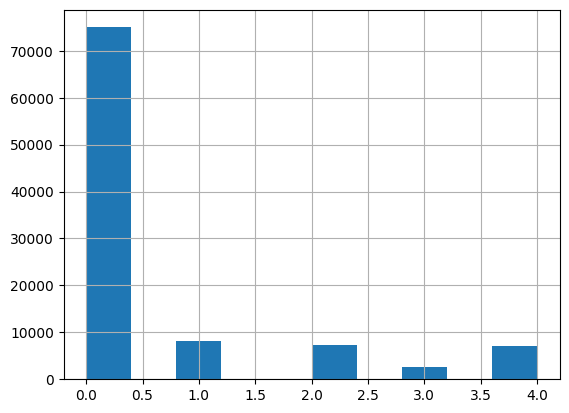

In [19]:
database['label'].hist();

## AutoML com sinais ruidosos

In [20]:
#removendo a coluna record_id pois ela não é necessária nas classificações 
noisy_database2 = noisy_database.iloc[:, :-1]
train_data, test_data = train_test_split(noisy_database2, random_state=42, stratify=noisy_database2.label)
train_data.shape, test_data.shape 

((75009, 361), (25003, 361))

In [21]:
X_train, y_train = train_data.iloc[:,:-1], train_data['label']
X_test, y_test = test_data.iloc[:,:-1], test_data['label']
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((75009, 360), (25003, 360), (75009,), (25003,))

In [22]:
%%time
predictor = TabularPredictor(label='label').fit(train_data, time_limit=28800, hyperparameter_tune_kwargs = 
                                                {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/76268bfd ...
	0.9952	 = Validation score   (accuracy)
	180.47s	 = Training   runtime
	0.24s	 = Validation runtime
Fitted model: NeuralNetTorch/c9d1cdda ...
	0.9874	 = Validation score   (accuracy)
	847.69s	 = Training   runtime
	0.75s	 = Validation runtime
Fitted model: NeuralNetTorch/6eeb88c7 ...
	0.996	 = Validation score   (accuracy)
	254.3s	 = Training   runtime
	0.2s	 = Validation runtime
Fitted model: NeuralNetTorch/efae2fdb ...
	0.9946	 = Validation score   (accuracy)
	169.36s	 = Training   runtime
	0.34s	 = Validation runtime
Fitted model: NeuralNetTorch/bffdccfa ...
	0.996	 = Validation score   (accuracy)
	228.66s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1993.7s of the 24408.46s of remaining time.
	0.9902	 = Validation score   (accuracy)
	168.66s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 2879.79s of the 24230.

CPU times: user 6h 4s, sys: 1min 47s, total: 6h 1min 51s
Wall time: 1h 16min 11s


In [131]:
y_pred_best = predictor.predict(data=X_test, model='NeuralNetFastAI/37546213')

In [132]:
print(classification_report(y_test, y_pred_best, digits=4))

              precision    recall  f1-score   support

           0     0.9954    0.9979    0.9966     18753
           1     0.9975    0.9970    0.9973      2018
           2     0.9978    0.9989    0.9983      1814
           3     0.9615    0.9041    0.9319       636
           4     0.9881    0.9826    0.9854      1782

    accuracy                         0.9944     25003
   macro avg     0.9881    0.9761    0.9819     25003
weighted avg     0.9943    0.9944    0.9943     25003



### Dataframe de hiperparâmetros

Iremos usar 3 métodos para os modelos do AutoGluon, o primeiro sem reamostragem, o segundo utilizando a técnica de reamostragem SMOTE e o terceiro a técnica de reamostragem ADASYN. Por isso, para auxiliar o acesso dos hiperparâmetros utilizaremos um dataframe.

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [23]:
def autogluon_models_df(window, filter_applied, resampling_tech, predictor_model, test_data_):
    leaderboard = predictor_model.leaderboard(test_data_, silent=True, extra_metrics=['accuracy','precision_weighted','recall_weighted', 'f1_weighted'])
    all_models = predictor_model.get_model_names()
    predictor_information = predictor_model.info()
    autogluon_accuracy = []
    autogluon_precision = []
    autogluon_f1 = []
    autogluon_recall = []
    autogluon_hyperparameters = []
    autogluon_algorithms = [] 
    for model in all_models:
        if model != 'WeightedEnsemble_L2':
            autogluon_algorithms.append(model)
            accuracy = (leaderboard.accuracy[leaderboard['model'] == model]).values[0]
            precision_weighted = (leaderboard.precision_weighted[leaderboard['model'] == model]).values[0]
            recall_weighted = (leaderboard.recall_weighted[leaderboard['model'] == model]).values[0]
            f1_weighted = (leaderboard.f1_weighted[leaderboard['model'] == model]).values[0]
            
            autogluon_accuracy.append(accuracy)
            autogluon_precision.append(precision_weighted)
            autogluon_recall.append(recall_weighted)
            autogluon_f1.append(f1_weighted)
            
            autogluon_hyperparameters.append(predictor_information["model_info"][model]["hyperparameters"])
            
    window_size_list = [window*2]*len(autogluon_algorithms)
    filter_applied_list = [filter_applied]*len(autogluon_algorithms)
    resampling_tech_list = [resampling_tech]*len(autogluon_algorithms)
        
    
    autogluon_args = list(zip(window_size_list, filter_applied_list, resampling_tech_list, 
                              autogluon_algorithms, autogluon_hyperparameters, autogluon_accuracy,
                             autogluon_precision, autogluon_recall, autogluon_f1))    
    
    hyperparameters = pd.DataFrame(autogluon_args, columns=['window_size','filter_applied','resampling_tech',
                                                            'model','hyperparameters','accuracy',
                                                            'precision_weighted','recall_weighted', 'f1_weighted'])
    
    hyperparameters = hyperparameters.sort_values(by='accuracy', ascending=False)
    hyperparameters = hyperparameters.reset_index(drop=True)
    
    #agrupamento por algoritmos
    hyperparameters['algorithm'] = ''
    all_algorithms = ['LightGBM', 'RandomForest', 'NeuralNetTorch', 'NeuralNetFastAI', 'XGBoost',
                      'ExtraTrees', 'CatBoost', 'KNeighbors']
    
    hyperparameters.loc[hyperparameters['model'].str.contains('LightGBM'), 'algorithm'] = 'LightGBM'
    hyperparameters.loc[hyperparameters['model'].str.contains('RandomForest'), 'algorithm'] = 'RandomForest'
    hyperparameters.loc[hyperparameters['model'].str.contains('NeuralNetTorch'), 'algorithm'] = 'NeuralNetTorch'
    hyperparameters.loc[hyperparameters['model'].str.contains('NeuralNetFastAI'), 'algorithm'] = 'NeuralNetFastAI'
    hyperparameters.loc[hyperparameters['model'].str.contains('XGBoost'), 'algorithm'] = 'XGBoost'
    hyperparameters.loc[hyperparameters['model'].str.contains('ExtraTrees'), 'algorithm'] = 'ExtraTrees'
    hyperparameters.loc[hyperparameters['model'].str.contains('CatBoost'), 'algorithm'] = 'CatBoost'
    hyperparameters.loc[hyperparameters['model'].str.contains('KNeighbors'), 'algorithm'] = 'KNeighbors'
    
    return hyperparameters

In [24]:
%%time
model_without_resampling = autogluon_models_df(window=window_size,
                                               filter_applied=False, 
                                               resampling_tech=None,
                                               predictor_model=predictor,
                                               test_data_=test_data)

/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 4min 38s, sys: 2.65 s, total: 4min 41s
Wall time: 46.4 s


**Ranking dos modelos sem reamostragem e sem filtro**

In [25]:
model_without_resampling.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/37546213,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994401,0.994346,0.994401,0.994349,NeuralNetFastAI
1,360,False,None,NeuralNetTorch/bffdccfa,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.3, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0029705977874861754, 'weight_decay': 3.366954449760058e-11, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'most_frequent', 'proc.max_category_levels': 10, 'proc.skew_threshold': 10.0, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.993681,0.993616,0.993681,0.993585,NeuralNetTorch


**Cálculo do intervalo de confiança**

In [133]:
z = 1.96
f1 = 0.994349
n = len(X_test)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.993419836619828, 0.995278163380172)


In [26]:
model_without_resampling['algorithm'].value_counts()

LightGBM           11
NeuralNetFastAI     5
NeuralNetTorch      5
XGBoost             5
CatBoost            3
KNeighbors          2
RandomForest        2
ExtraTrees          2
Name: algorithm, dtype: int64

In [27]:
model_without_resampling['algorithm'].value_counts().sum()

35

Para evitar perda dos dados

In [28]:
model_without_resampling.to_csv('model_without_resampling.csv', index=False)

### AutoML com técnica de reamostragem SMOTE

In [29]:
# Aplicar SMOTE apenas no conjunto de treinamento
smote = SMOTE(sampling_strategy='auto')

In [30]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train))

Distribuição de classes sem a reamostragem:  Counter({0: 56258, 1: 6053, 2: 5441, 4: 5347, 3: 1910})


In [31]:
%%time
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

CPU times: user 8.33 s, sys: 682 ms, total: 9.01 s
Wall time: 3.07 s


In [32]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_smote))

Distribuição de classes após a reamostragem:  Counter({1: 56258, 0: 56258, 4: 56258, 2: 56258, 3: 56258})


In [33]:
resampled_smote = X_resampled_smote.join(y_resampled_smote)
resampled_smote.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,label
0,0.098172,0.087535,0.034351,0.044988,0.044988,0.076899,0.098172,0.087535,0.066262,0.044988,...,-0.997419,-1.093150,-1.188882,-1.220792,-1.199518,-1.125061,-1.018693,-0.869777,-0.805956,1
1,-0.308763,-0.323578,-0.353210,-0.382842,-0.412473,-0.456921,-0.397657,-0.353210,-0.293947,-0.249499,...,-0.575447,-0.575447,-0.545815,-0.531000,-0.486552,-0.501368,-0.412473,-0.368026,-0.308763,0
2,-0.352679,-0.362016,-0.390028,-0.390028,-0.380691,-0.334004,-0.315330,-0.324667,-0.315330,-0.334004,...,-0.418040,-0.427378,-0.455390,-0.427378,-0.390028,-0.380691,-0.371354,-0.380691,-0.390028,4
3,0.083793,0.052694,0.021596,-0.030236,-0.061334,-0.061334,-0.071701,-0.082067,-0.061334,-0.071701,...,-0.403420,-0.631478,-0.797337,-0.755872,-0.631478,-0.475984,-0.403420,-0.403420,-0.507083,0
4,-0.489525,-0.560440,-0.542711,-0.507254,-0.436340,-0.489525,-0.507254,-0.578168,-0.560440,-0.418611,...,-0.613625,-0.560440,-0.542711,-0.613625,-0.631354,-0.666811,-0.631354,-0.560440,-0.578168,4


In [34]:
%%time
smote_resampling_training = TabularPredictor(label='label').fit(resampled_smote, time_limit=28800, 
                                                                hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/3b871330 ...
	0.9991	 = Validation score   (accuracy)
	337.18s	 = Training   runtime
	0.2s	 = Validation runtime
Fitted model: NeuralNetTorch/9479b6a1 ...
	0.9996	 = Validation score   (accuracy)
	795.01s	 = Training   runtime
	0.24s	 = Validation runtime
Fitted model: NeuralNetTorch/2a5b3c24 ...
	0.9876	 = Validation score   (accuracy)
	341.41s	 = Training   runtime
	0.2s	 = Validation runtime
Fitted model: NeuralNetTorch/21a95341 ...
	0.9495	 = Validation score   (accuracy)
	311.84s	 = Training   runtime
	0.63s	 = Validation runtime
Fitted model: NeuralNetTorch/c03202e3 ...
	0.9572	 = Validation score   (accuracy)
	680.18s	 = Training   runtime
	0.4s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1993.17s of the 18244.76s of remaining time.
	0.9993	 = Validation score   (accuracy)
	488.16s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 2879.02s of the 1773

CPU times: user 17h 56min 16s, sys: 4min 5s, total: 18h 22s
Wall time: 3h 4min 30s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [35]:
%%time
models_with_smote = autogluon_models_df(window=window_size,
                                        filter_applied=False, 
                                        resampling_tech='smote',
                                        predictor_model=smote_resampling_training,
                                        test_data_=test_data)

CPU times: user 13min 50s, sys: 4.69 s, total: 13min 54s
Wall time: 1min 44s


**Ranking dos modelos com a técnica de reamostragem SMOTE e sem filtro**

In [36]:
models_with_smote.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,smote,NeuralNetTorch/9479b6a1,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.1, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.3, 'optimizer': 'adam', 'learning_rate': 0.0002743558076081783, 'weight_decay': 5.0044368612174e-08, 'proc.embed_min_categories': 1000, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 10000, 'proc.skew_threshold': 0.9, 'use_ngram_features': False, 'num_layers': 2, 'hidden_size': 512, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.993361,0.993375,0.993361,0.993367,NeuralNetTorch
1,360,False,smote,NeuralNetFastAI/3e815706,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.992681,0.992806,0.992681,0.992730,NeuralNetFastAI


**Cálculo do intervalo de confiança**

In [134]:
z = 1.96
f1 = 0.993367
n = len(X_test)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9923608334530273, 0.9943731665469727)


In [37]:
models_with_smote['algorithm'].value_counts()

LightGBM           9
NeuralNetTorch     5
NeuralNetFastAI    5
XGBoost            4
ExtraTrees         2
RandomForest       2
KNeighbors         2
CatBoost           1
Name: algorithm, dtype: int64

In [38]:
models_with_smote['algorithm'].value_counts().sum()

30

Para evitar perda dos dados

In [39]:
models_with_smote.to_csv('models_with_smote.csv', index=False)

**Junção dos modelos**

In [40]:
hyperparameters_all_models = pd.concat([models_with_smote, model_without_resampling])

In [41]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [42]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [43]:
hyperparameters_all_models.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/37546213,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994401,0.994346,0.994401,0.994349,NeuralNetFastAI
1,360,False,None,NeuralNetTorch/bffdccfa,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.3, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0029705977874861754, 'weight_decay': 3.366954449760058e-11, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'most_frequent', 'proc.max_category_levels': 10, 'proc.skew_threshold': 10.0, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.993681,0.993616,0.993681,0.993585,NeuralNetTorch


### AutoML com técnica de reamostragem ADASYN

In [44]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train))

Distribuição de classes sem a reamostragem:  Counter({0: 56258, 1: 6053, 2: 5441, 4: 5347, 3: 1910})


In [45]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

In [46]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_adasyn))

Distribuição de classes após a reamostragem:  Counter({0: 56258, 3: 56201, 1: 6053, 2: 5441, 4: 5347})


In [47]:
resampled_adasyn = X_resampled_adasyn.join(y_resampled_adasyn)

In [48]:
%%time
adasyn_resampling_training = TabularPredictor(label='label').fit(resampled_adasyn, time_limit=28800,
                                                                 hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/4e205784 ...
	0.9982	 = Validation score   (accuracy)
	258.03s	 = Training   runtime
	0.36s	 = Validation runtime
Fitted model: NeuralNetTorch/62ab1405 ...
	0.9572	 = Validation score   (accuracy)
	149.02s	 = Training   runtime
	0.64s	 = Validation runtime
Fitted model: NeuralNetTorch/9bd14f75 ...
	0.9956	 = Validation score   (accuracy)
	600.2s	 = Training   runtime
	0.47s	 = Validation runtime
Fitted model: NeuralNetTorch/df1c8cee ...
	0.9932	 = Validation score   (accuracy)
	1974.14s	 = Training   runtime
	2.43s	 = Validation runtime
Fitted model: NeuralNetTorch/5e2d32b0 ...
	0.9988	 = Validation score   (accuracy)
	451.47s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1993.54s of the 20933.44s of remaining time.
	0.9974	 = Validation score   (accuracy)
	328.5s	 = Training   runtime
	0.37s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 2879.55s of the 20

CPU times: user 10h 16min 20s, sys: 2min 48s, total: 10h 19min 8s
Wall time: 2h 16min 56s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [49]:
%%time
models_with_adasyn = autogluon_models_df(window=window_size,
                                        filter_applied=False, 
                                        resampling_tech='adasyn',
                                        predictor_model=adasyn_resampling_training,
                                        test_data_=test_data)

/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 9min 44s, sys: 3.9 s, total: 9min 47s
Wall time: 1min 31s


**Ranking dos modelos com a técnica de reamostragem ADASYN e sem filtro**

In [50]:
models_with_adasyn.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,adasyn,NeuralNetFastAI/36f55ba9,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993961,0.993959,0.993961,0.993959,NeuralNetFastAI
1,360,False,adasyn,NeuralNetTorch/4e205784,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.0, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.1, 'optimizer': 'adam', 'learning_rate': 0.0003, 'weight_decay': 1e-06, 'proc.embed_min_categories': 4, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 100, 'proc.skew_threshold': 0.99, 'use_ngram_features': False, 'num_layers': 2, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': False, 'loss_function': 'auto'}",0.992881,0.992908,0.992881,0.992893,NeuralNetTorch


**Cálculo do intervalo de confiança**

In [135]:
z = 1.96
f1 = 0.993959
n = len(X_test)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9929984971363329, 0.9949195028636671)


In [51]:
models_with_adasyn['algorithm'].value_counts()

LightGBM           10
NeuralNetFastAI     5
NeuralNetTorch      5
XGBoost             5
ExtraTrees          2
RandomForest        2
KNeighbors          2
CatBoost            1
Name: algorithm, dtype: int64

In [52]:
models_with_adasyn['algorithm'].value_counts().sum()

32

Para evitar perda dos dados

In [53]:
models_with_adasyn.to_csv('models_with_adasyn.csv', index=False)

**Junção dos modelos**

In [54]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, models_with_adasyn])

In [55]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [56]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [57]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/37546213,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994401,0.994346,0.994401,0.994349,NeuralNetFastAI
1,360,False,adasyn,NeuralNetFastAI/36f55ba9,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993961,0.993959,0.993961,0.993959,NeuralNetFastAI
2,360,False,None,NeuralNetTorch/bffdccfa,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.3, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0029705977874861754, 'weight_decay': 3.366954449760058e-11, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'most_frequent', 'proc.max_category_levels': 10, 'proc.skew_threshold': 10.0, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.993681,0.993616,0.993681,0.993585,NeuralNetTorch
3,360,False,None,NeuralNetFastAI/99b3623d,"{'layers': (200, 100), 'emb_drop': 0.13265846715063284, 'ps': 0.08147640949298857, 'bs': 256, 'lr': 0.0005375243850685625, 'epochs': 28, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993441,0.993368,0.993441,0.993353,NeuralNetFastAI
4,360,False,smote,NeuralNetTorch/9479b6a1,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.1, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.3, 'optimizer': 'adam', 'learning_rate': 0.0002743558076081783, 'weight_decay': 5.0044368612174e-08, 'proc.embed_min_categories': 1000, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 10000, 'proc.skew_threshold': 0.9, 'use_ngram_features': False, 'num_layers': 2, 'hidden_size': 512, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.993361,0.993375,0.993361,0.993367,NeuralNetTorch


## AutoML com redução de ruído

In [58]:
#removendo a coluna record_id pois ela não é necessária nas classificações 
database2 = database.iloc[:, :-1]
train_data2, test_data2 = train_test_split(database2, random_state=42, stratify=database2.label)
train_data2.shape, test_data2.shape 

((75009, 361), (25003, 361))

In [59]:
X_train2, y_train2 = train_data2.iloc[:,:-1], train_data2['label']
X_test2, y_test2 = test_data2.iloc[:,:-1], test_data2['label']
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((75009, 360), (25003, 360), (75009,), (25003,))

In [60]:
%%time
predictor2 = TabularPredictor(label='label').fit(train_data2, time_limit=28800, hyperparameter_tune_kwargs = 
                                                {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/ac8e762a ...
	0.9944	 = Validation score   (accuracy)
	93.3s	 = Training   runtime
	0.39s	 = Validation runtime
Fitted model: NeuralNetTorch/73ba7075 ...
	0.995	 = Validation score   (accuracy)
	177.58s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: NeuralNetTorch/ab2c5eab ...
	0.75	 = Validation score   (accuracy)
	94.98s	 = Training   runtime
	0.35s	 = Validation runtime
Fitted model: NeuralNetTorch/c0ac1750 ...
	0.9918	 = Validation score   (accuracy)
	344.4s	 = Training   runtime
	0.4s	 = Validation runtime
Fitted model: NeuralNetTorch/6c499a84 ...
	0.9946	 = Validation score   (accuracy)
	205.73s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1993.64s of the 25246.47s of remaining time.
	0.9936	 = Validation score   (accuracy)
	127.85s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 2879.7s of the 25110.12s 

CPU times: user 5h 42min 48s, sys: 1min 14s, total: 5h 44min 2s
Wall time: 1h 1min 32s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [61]:
%%time
model_without_resampling2 = autogluon_models_df(window=window_size,
                                        filter_applied=True, 
                                        resampling_tech=None,
                                        predictor_model=predictor2,
                                        test_data_=test_data2)

/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 4min 15s, sys: 2.45 s, total: 4min 18s
Wall time: 44 s


**Ranking dos modelos com a técnica de reamostragem ADASYN e sem filtro**

In [62]:
model_without_resampling2.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994081,0.994048,0.994081,0.993997,LightGBM
1,360,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.994041,0.994006,0.994041,0.993966,LightGBM


**Cálculo do intervalo de confiança**

In [136]:
z = 1.96
f1 = 0.993997
n = len(X_test2)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9930395045488315, 0.9949544954511685)


In [63]:
model_without_resampling2['algorithm'].value_counts()

LightGBM           11
NeuralNetFastAI     5
NeuralNetTorch      5
XGBoost             5
CatBoost            3
KNeighbors          2
ExtraTrees          2
RandomForest        2
Name: algorithm, dtype: int64

In [64]:
model_without_resampling2['algorithm'].value_counts().sum()

35

Para evitar perda dos dados

In [65]:
model_without_resampling2.to_csv('model_without_resampling2.csv', index=False)

**Junção dos modelos**

In [66]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, model_without_resampling2])

In [67]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [68]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [69]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/37546213,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994401,0.994346,0.994401,0.994349,NeuralNetFastAI
1,360,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994081,0.994048,0.994081,0.993997,LightGBM
2,360,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.994041,0.994006,0.994041,0.993966,LightGBM
3,360,False,adasyn,NeuralNetFastAI/36f55ba9,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993961,0.993959,0.993961,0.993959,NeuralNetFastAI
4,360,True,None,LightGBMXT/T5,"{'learning_rate': 0.1000260297171191, 'extra_trees': True, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.993801,0.993770,0.993801,0.993706,LightGBM


### AutoML com técnica de reamostragem SMOTE

In [70]:
# Aplicar SMOTE apenas no conjunto de treinamento
smote2 = SMOTE(sampling_strategy='auto')

In [71]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train2))

Distribuição de classes sem a reamostragem:  Counter({0: 56258, 1: 6053, 2: 5441, 4: 5347, 3: 1910})


In [72]:
%%time
X_resampled_smote2, y_resampled_smote2 = smote2.fit_resample(X_train2, y_train2)

CPU times: user 7.85 s, sys: 782 ms, total: 8.64 s
Wall time: 3.07 s


In [73]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_smote2))

Distribuição de classes após a reamostragem:  Counter({1: 56258, 0: 56258, 4: 56258, 2: 56258, 3: 56258})


In [74]:
resampled_smote2 = X_resampled_smote2.join(y_resampled_smote2)
resampled_smote2.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,label
0,0.008124,0.015677,0.020455,0.024539,0.026541,0.027155,0.027535,0.026990,0.026212,0.025200,...,-1.155663,-1.206291,-1.239591,-1.252329,-1.246351,-1.225124,-1.194193,-1.159795,-1.129093,1
1,-0.736922,-0.749586,-0.761418,-0.768311,-0.769856,-0.763590,-0.746639,-0.723108,-0.695870,-0.669032,...,-0.055097,-0.044900,-0.025687,0.000077,0.033625,0.071672,0.114629,0.158390,0.201314,0
2,-0.436176,-0.485041,-0.521780,-0.544266,-0.553989,-0.554136,-0.550021,-0.545684,-0.543463,-0.544207,...,-0.127656,-0.126182,-0.123452,-0.117977,-0.111670,-0.106659,-0.104004,-0.104345,-0.106617,4
3,-0.552203,-0.573895,-0.598598,-0.622541,-0.642208,-0.657600,-0.668714,-0.674548,-0.672337,-0.662332,...,-0.324201,-0.350999,-0.363740,-0.360916,-0.353081,-0.352292,-0.366089,-0.394972,-0.437185,0
4,-0.606583,-0.605663,-0.603877,-0.599932,-0.595120,-0.593321,-0.590655,-0.587123,-0.579708,-0.569271,...,-0.463468,-0.481132,-0.497076,-0.512162,-0.524666,-0.532865,-0.536328,-0.536778,-0.538095,4


In [75]:
%%time
smote_resampling_training2 = TabularPredictor(label='label').fit(resampled_smote2, time_limit=28800,
                                                                 hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/6a55c9e2 ...
	0.9996	 = Validation score   (accuracy)
	370.07s	 = Training   runtime
	0.34s	 = Validation runtime
Fitted model: NeuralNetTorch/4e63d377 ...
	0.9915	 = Validation score   (accuracy)
	385.55s	 = Training   runtime
	0.35s	 = Validation runtime
Fitted model: NeuralNetTorch/dadba6f3 ...
	0.9993	 = Validation score   (accuracy)
	502.34s	 = Training   runtime
	0.35s	 = Validation runtime
Fitted model: NeuralNetTorch/75a74c83 ...
	0.9991	 = Validation score   (accuracy)
	764.38s	 = Training   runtime
	0.35s	 = Validation runtime
Fitted model: NeuralNetTorch/fdbf045e ...
	0.9758	 = Validation score   (accuracy)
	516.17s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1993.09s of the 18548.66s of remaining time.
	0.9993	 = Validation score   (accuracy)
	299.55s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 2878.91s of the 1

CPU times: user 16h 27min 16s, sys: 3min 38s, total: 16h 30min 54s
Wall time: 2h 56min 16s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [76]:
%%time
models_with_smote2 = autogluon_models_df(window=window_size,
                                        filter_applied=True, 
                                        resampling_tech='smote',
                                        predictor_model=smote_resampling_training2,
                                        test_data_=test_data2)

CPU times: user 13min 9s, sys: 4.57 s, total: 13min 14s
Wall time: 1min 40s


**Ranking dos modelos com a técnica de reamostragem SMOTE e com filtro**

In [77]:
models_with_smote2.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,smote,NeuralNetFastAI/5bd0550d,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994081,0.994118,0.994081,0.994097,NeuralNetFastAI
1,360,True,smote,LightGBM/T5,"{'learning_rate': 0.1000260297171191, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.993801,0.993804,0.993801,0.993802,LightGBM


**Cálculo do intervalo de confiança**

In [137]:
z = 1.96
f1 = 0.994097
n = len(X_test2)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9931474654228719, 0.9950465345771281)


In [78]:
models_with_smote2['algorithm'].value_counts()

LightGBM           11
NeuralNetFastAI     5
NeuralNetTorch      5
XGBoost             4
CatBoost            3
ExtraTrees          2
RandomForest        2
KNeighbors          2
Name: algorithm, dtype: int64

In [79]:
models_with_smote2['algorithm'].value_counts().sum()

34

Para evitar perda dos dados

In [80]:
models_with_smote2.to_csv('models_with_smote2.csv', index=False)

**Junção dos modelos**

In [81]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, models_with_smote2])

In [82]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [83]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [84]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/37546213,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994401,0.994346,0.994401,0.994349,NeuralNetFastAI
1,360,True,smote,NeuralNetFastAI/5bd0550d,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994081,0.994118,0.994081,0.994097,NeuralNetFastAI
2,360,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994081,0.994048,0.994081,0.993997,LightGBM
3,360,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.994041,0.994006,0.994041,0.993966,LightGBM
4,360,False,adasyn,NeuralNetFastAI/36f55ba9,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993961,0.993959,0.993961,0.993959,NeuralNetFastAI


### AutoML com técnica de reamostragem ADASYN

In [85]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train2))

Distribuição de classes sem a reamostragem:  Counter({0: 56258, 1: 6053, 2: 5441, 4: 5347, 3: 1910})


In [86]:
adasyn2 = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled_adasyn2, y_resampled_adasyn2 = adasyn.fit_resample(X_train2, y_train2)

In [87]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_adasyn2))

Distribuição de classes após a reamostragem:  Counter({3: 56288, 0: 56258, 1: 6053, 2: 5441, 4: 5347})


In [88]:
resampled_adasyn2 = X_resampled_adasyn2.join(y_resampled_adasyn2)

In [89]:
%%time
adasyn_resampling_training2 = TabularPredictor(label='label').fit(resampled_adasyn2, time_limit=28800,
                                                                  hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/d7c80f6d ...
	0.9982	 = Validation score   (accuracy)
	189.49s	 = Training   runtime
	0.38s	 = Validation runtime
Fitted model: NeuralNetTorch/a931bff5 ...
	0.989	 = Validation score   (accuracy)
	203.67s	 = Training   runtime
	0.63s	 = Validation runtime
Fitted model: NeuralNetTorch/20fcf9f7 ...
	0.988	 = Validation score   (accuracy)
	232.47s	 = Training   runtime
	0.5s	 = Validation runtime
Fitted model: NeuralNetTorch/3099c3c7 ...
	0.9848	 = Validation score   (accuracy)
	282.99s	 = Training   runtime
	0.33s	 = Validation runtime
Fitted model: NeuralNetTorch/1f192d46 ...
	0.9942	 = Validation score   (accuracy)
	525.88s	 = Training   runtime
	0.51s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 1993.49s of the 22454.46s of remaining time.
	0.997	 = Validation score   (accuracy)
	225.53s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 2879.49s of the 22214

CPU times: user 10h 13min 25s, sys: 2min 21s, total: 10h 15min 47s
Wall time: 1h 49min 48s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [90]:
%%time
models_with_adasyn2 = autogluon_models_df(window=window_size,
                                        filter_applied=True, 
                                        resampling_tech='adasyn',
                                        predictor_model=adasyn_resampling_training2,
                                        test_data_=test_data2)

CPU times: user 7min 41s, sys: 3.32 s, total: 7min 44s
Wall time: 1min 12s


**Ranking dos modelos com a técnica de reamostragem SMOTE e com filtro**

In [91]:
models_with_adasyn2.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,adasyn,NeuralNetFastAI/7317054f,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993961,0.994008,0.993961,0.993979,NeuralNetFastAI
1,360,True,adasyn,LightGBMXT/T5,"{'learning_rate': 0.1000260297171191, 'extra_trees': True, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.993881,0.993902,0.993881,0.993887,LightGBM


**Cálculo do intervalo de confiança**

In [138]:
z = 1.96
f1 = 0.993979
n = len(X_test2)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9930200787804425, 0.9949379212195574)


In [92]:
models_with_adasyn2['algorithm'].value_counts()

LightGBM           11
NeuralNetFastAI     5
NeuralNetTorch      5
XGBoost             5
CatBoost            3
ExtraTrees          2
RandomForest        2
KNeighbors          2
Name: algorithm, dtype: int64

In [93]:
models_with_adasyn2['algorithm'].value_counts().sum()

35

Para evitar perda dos dados

In [94]:
models_with_adasyn2.to_csv('models_with_adasyn2.csv', index=False)

**Junção dos modelos**

In [95]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, models_with_adasyn2])

In [96]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [97]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [98]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/37546213,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994401,0.994346,0.994401,0.994349,NeuralNetFastAI
1,360,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994081,0.994048,0.994081,0.993997,LightGBM
2,360,True,smote,NeuralNetFastAI/5bd0550d,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994081,0.994118,0.994081,0.994097,NeuralNetFastAI
3,360,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.994041,0.994006,0.994041,0.993966,LightGBM
4,360,True,adasyn,NeuralNetFastAI/7317054f,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993961,0.994008,0.993961,0.993979,NeuralNetFastAI


In [127]:
hyperparameters_all_models.to_csv('all_models-vfinal_seg360_5classes.csv', index=False)

## Análise dos modelos

In [99]:
hyperparameters_all_models.algorithm.value_counts()

LightGBM           63
NeuralNetFastAI    30
NeuralNetTorch     30
XGBoost            28
CatBoost           14
ExtraTrees         12
RandomForest       12
KNeighbors         12
Name: algorithm, dtype: int64

**Melhores modelos por algoritmo**

In [100]:
hyperparameters_all_models['algorithm'].head(10)

0    NeuralNetFastAI
1           LightGBM
2    NeuralNetFastAI
3           LightGBM
4    NeuralNetFastAI
5    NeuralNetFastAI
6           LightGBM
7           LightGBM
8           LightGBM
9         ExtraTrees
Name: algorithm, dtype: object

**Melhores modelos por algoritmo**

In [115]:
all_algorithms = ['LightGBM', 'RandomForest', 'NeuralNetTorch', 'NeuralNetFastAI', 'XGBoost',
                      'ExtraTrees', 'CatBoost', 'KNeighbors']
best_models = pd.DataFrame()
for i in all_algorithms:
    new_model = hyperparameters_all_models[hyperparameters_all_models['algorithm'] == i].head(1)
    best_models = pd.concat([best_models, new_model], ignore_index=True)

In [116]:
best_models = best_models.sort_values(by='accuracy', ascending=False)

In [117]:
best_models = best_models.reset_index(drop=True)

In [128]:
best_models.to_csv('best_models-vfinal_seg360_5classes.csv', index=False)

In [118]:
best_models.shape

(8, 10)

In [119]:
best_models

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/37546213,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994401,0.994346,0.994401,0.994349,NeuralNetFastAI
1,360,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994081,0.994048,0.994081,0.993997,LightGBM
2,360,True,smote,ExtraTreesEntr,"{'n_estimators': 300, 'max_leaf_nodes': 15000, 'n_jobs': -1, 'random_state': 0, 'bootstrap': True, 'criterion': 'entropy'}",0.993721,0.993705,0.993721,0.993710,ExtraTrees
3,360,False,None,NeuralNetTorch/bffdccfa,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.3, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.4, 'optimizer': 'adam', 'learning_rate': 0.0029705977874861754, 'weight_decay': 3.366954449760058e-11, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'most_frequent', 'proc.max_category_levels': 10, 'proc.skew_threshold': 10.0, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.993681,0.993616,0.993681,0.993585,NeuralNetTorch
4,360,True,smote,XGBoost/T2,"{'n_estimators': 10000, 'learning_rate': 0.06994332504138302, 'n_jobs': -1, 'proc.max_category_levels': 100, 'objective': 'multi:softmax', 'booster': 'gbtree', 'num_class': 5, 'max_depth': 6, 'min_child_weight': 4, 'colsample_bytree': 0.7744067519636624}",0.993321,0.993382,0.993321,0.993346,XGBoost
5,360,True,smote,RandomForestEntr,"{'n_estimators': 300, 'max_leaf_nodes': 15000, 'n_jobs': -1, 'random_state': 0, 'bootstrap': True, 'criterion': 'entropy'}",0.993281,0.993260,0.993281,0.993267,RandomForest
6,360,True,None,CatBoost/T3,"{'iterations': 10000, 'learning_rate': 0.02386109712430462, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy', 'depth': 8, 'l2_leaf_reg': 3.1795327319875875}",0.991641,0.991590,0.991641,0.991486,CatBoost
7,360,True,None,KNeighborsDist,{'weights': 'distance'},0.991041,0.990924,0.991041,0.990890,KNeighbors


## Conclusão

In [120]:
hyperparameters_all_models.shape

(201, 10)

In [121]:
hyperparameters_all_models.head(10)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/37546213,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994401,0.994346,0.994401,0.994349,NeuralNetFastAI
1,360,True,None,LightGBMXT/T1,"{'learning_rate': 0.05, 'extra_trees': True, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'num_leaves': 31}",0.994081,0.994048,0.994081,0.993997,LightGBM
2,360,True,smote,NeuralNetFastAI/5bd0550d,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.994081,0.994118,0.994081,0.994097,NeuralNetFastAI
3,360,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.994041,0.994006,0.994041,0.993966,LightGBM
4,360,True,adasyn,NeuralNetFastAI/7317054f,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993961,0.994008,0.993961,0.993979,NeuralNetFastAI
5,360,False,adasyn,NeuralNetFastAI/36f55ba9,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.993961,0.993959,0.993961,0.993959,NeuralNetFastAI
6,360,True,adasyn,LightGBMXT/T5,"{'learning_rate': 0.1000260297171191, 'extra_trees': True, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.993881,0.993902,0.993881,0.993887,LightGBM
7,360,True,None,LightGBMXT/T5,"{'learning_rate': 0.1000260297171191, 'extra_trees': True, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.993801,0.993770,0.993801,0.993706,LightGBM
8,360,True,smote,LightGBM/T5,"{'learning_rate': 0.1000260297171191, 'feature_fraction': 0.8694162793303375, 'min_data_in_leaf': 48, 'num_leaves': 53}",0.993801,0.993804,0.993801,0.993802,LightGBM
9,360,True,smote,ExtraTreesEntr,"{'n_estimators': 300, 'max_leaf_nodes': 15000, 'n_jobs': -1, 'random_state': 0, 'bootstrap': True, 'criterion': 'entropy'}",0.993721,0.993705,0.993721,0.993710,ExtraTrees


In [122]:
(hyperparameters_all_models.head(10).algorithm == 'NeuralNetFastAI').sum()

4

In [123]:
(hyperparameters_all_models.head(10).algorithm == 'LightGBM').sum()

5

In [124]:
hyperparameters_all_models.head(10).algorithm

0    NeuralNetFastAI
1           LightGBM
2    NeuralNetFastAI
3           LightGBM
4    NeuralNetFastAI
5    NeuralNetFastAI
6           LightGBM
7           LightGBM
8           LightGBM
9         ExtraTrees
Name: algorithm, dtype: object

In [125]:
best_models.filter_applied.sum()

6

In [126]:
best_models.resampling_tech.value_counts()

smote    3
Name: resampling_tech, dtype: int64